In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import spacy
import nltk
import re

# modeling
import xgboost as xg
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

# Dimension reduction and clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


# model selection and hyper-parameters tuning
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe   #Bayesian Search

# for scoring
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import probplot


# Load spaCy model  for string encoding
nlp = spacy.load("en_core_web_sm")

# Download the stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

In [2]:
file_path = '../dataset/AB_NYC_2019.csv'

data = pd.read_csv('../dataset/AB_NYC_2019.csv')

data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0



# Helper functions

In [3]:
def get_cartesian(lat=None,lon=None):
    '''
    Converts latitude and longitude arrays into (x,y,z) coordinates
    Input :
          latitude as array
          longitude as array
    Output :
          x,y,z cartesian coordinates
    '''
    # Change degrees to radians
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 1 # radius of the earth = 6371 km but not needed as we will normalize

    # Convert to cartesian
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)

    return x,y,z

def lambda_n(n,k,f):
    '''
    Compute the blending factor using a sigmoid function.
    
    Inputs :
        n : Pandas series with the counts for each category (the id must be the categories)
        k : translation parameter. The sigmoid give 0.5 when n=k
        f:  steepness parameter. The lower it is, the steeper.

    Output:
        Pandas Series with the blending factors for each cell item
    
    '''
    return 1/(1+np.exp(-(n-k)/f))

def target_encoding(df_train, feature, target, aggregate, kf_dict, hierarchy=None,):
    '''
    Target encoding using blending factor and accounting for hierarchy.
    
    Inputs :
            df_train : DataFrame used as the training set
            feature : string or list of strings representing all the features to take into account
            target : string indicating the target on which to do the encoding
            aggregate : callable (compatible with DataFrame) specifying which type of aggregation to perform (mean,median, sum, etc.)
            hirarchy : list of features to consider for upper hierarchy
    Outputs :
            dictionary where key = feature and value = target encoding
    '''
    # if feature is list, convert it to tuple
    if type(feature) is not str:
        feature = list(feature)
    
    # Compute the aggregate of the target variable for each category
    agg_by_feature = df_train.groupby(feature)[target].agg(aggregate).to_dict()
    
    # Compute the global aggregate
    agg = df_train[target].agg(aggregate)
    
    # Compute the counts for each category
    n = df_train.groupby(feature)[target].count()
    
    # Fetch k and f hyperparameters used in the blending function
    if type(feature) is not str:
        feature = tuple(feature)
    
    k,f = kf_dict.get(feature,(12,5))
    
    # Compute the blending factor
    lambda_factor = lambda_n(n,k,f).to_dict()
    
    # Compute target encoding
    if hierarchy == None:
        target_dict = {k: lambda_factor[k]*agg_by_feature[k] + (1-lambda_factor[k])*agg for k in lambda_factor}
    else:
        target_dict = {k: lambda_factor[k]*agg_by_feature[k] + (1-lambda_factor[k])*agg for k in lambda_factor}

    return target_dict

def clean_text(text):
    '''
    A function to remove stop words and special characters
    input :
        text as string
    Output:
        text as string
    '''
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def process_batch(batch):
    '''
    Function to encode a single batch of texts
    Input: 
            texts : a sequence (Series, list, array, etc.) of strings
            
    Output:
            vecs : list of encoded vectors for each string
    '''
    
    vecs = []
    for doc in nlp.pipe(batch):
        if len(doc) > 0:
            vec = np.mean([word.vector for word in doc], axis=0)
            vecs.append(vec)
        else: 
            vecs.append(np.zeros(96))
    return np.vstack(vecs)

def encode_texts(texts, batch_size=1000):
    '''
    Function to encode many texts by batches
    Input: 
            texts : a sequence (Series, list, array, etc.) of strings 
            
    Output:
            vecs : list of encoded vectors for each string
    ''' 
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        vecs.append(process_batch(batch))
    return np.vstack(vecs)

def compare_norm_dist(series,plots = True):
    '''
    This function takes a series as input and compares it to a normal distribution.
    It also returns the thresholds over which the distribution is not normal anymore.
    It was used to trim out outliers.
    
    Input:
        series : pandas.Series representing the data to compare with a normal
    
    Outputs:
        plots visualizations : histogram, box plot, and QQplot
        upper boundary:  float representing bound over which data is less than 3*std from the mean 
        lower boundary:  float representing bound over which data is less than 3*std from the mean
    
    '''
    
    
    
    # mean and standard deviation
    mu, std = norm.fit(series) 

    
    upper_boundary=mu + 3* std
    lower_boundary=mu - 3* std

    if plots == True:
        # Plot the histogram.
        plt.hist(series, bins=25, density=True, alpha=0.6, color='orange', label='data')
        plt.axvline(upper_boundary,linestyle='dashed',linewidth='0.5', color='black',label='upper bound')
        plt.axvline(lower_boundary,linestyle='dashed',linewidth='0.5', color='black',label='lower bound')

        # Plot the PDF.
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)

        plt.plot(x, p, 'k', linewidth=2,label='Theoretical normal')
        title = "Mean and Std Values: {:.2f} and {:.2f}".format(mu, std)
        plt.title(title)
        plt.legend()

        # Boxplot figure
        plt.figure()
        sns.boxplot(series)
        plt.axhline(upper_boundary,linestyle='dashed',linewidth='0.5', color='black',label='upper bound')
        plt.axhline(lower_boundary,linestyle='dashed',linewidth='0.5', color='black',label='lower bound')
        plt.legend()

        plt.figure()
        # Create a QQ-plot of the log_price variable
        fig, ax = plt.subplots()
        probplot(series, dist = 'norm', plot = ax)
        ax.set_title('QQ-plot of log_log_price')
        ax.set_xlabel('Theoretical quantiles')
        ax.set_ylabel('Sample quantiles')
        plt.axhline(upper_boundary,linestyle='dashed',linewidth='0.5', color='black',label='upper bound')
        plt.axhline(lower_boundary,linestyle='dashed',linewidth='0.5', color='black',label='lower bound')
        plt.legend()
    
    return upper_boundary,lower_boundary

def preprocess(file_path,test_size=0.2,random_state=100):
    '''
    Fetches files in a given path and preprocess them to return a feature matrix X (dataframe) and target values y (dataframe)
    Input :
        files: path as string
        final_test_set: a boolean that is used only for the final test set
    Outputs : 
        X_train : Train Feature matrix as DataFrame
        y_train : Train Target values as Series
        X_test : Test Feature matrix as DataFrame
        y_test : Test Target values as Series
    '''
    #Load file
    df = pd.read_csv(file_path)

    # Remove entries with no price
    df = df[df['price']!=0]
    df = df[df['availability_365']!=0]

    # Replace NaN values by 0
    df['number_of_reviews'].fillna(0, inplace=True)
    df['reviews_per_month'].fillna(0, inplace=True)
    df['name'].fillna('Unnamed', inplace=True)
    df['last_review'].fillna('2099-01-01',inplace=True)

    # Processing dates
    df['last_review'] = pd.to_datetime(df['last_review'])
    df['last_review_day'] = df['last_review'].dt.day
    df['last_review_month'] = df['last_review'].dt.month
    df['last_review_year'] = df['last_review'].dt.year
    
    #One hot encoding of 'room_type'
    neig= df['neighbourhood_group'].copy()
    df = pd.get_dummies(df, columns=['room_type','neighbourhood_group'])
    df['neighbourhood_group']= neig
    
    #Transform latitude and longitude in cartesian coordinates (x,y,z) (Earth as a 3D sphere and (0,0,0) its center)
    zone = df[['latitude','longitude']].to_numpy()
    x,y,z = get_cartesian(zone[:,0],zone[:,1])
    df= df.drop(['latitude','longitude'], axis=1)
    df['x'] = x
    df['y'] = y
    df['z'] = z
        
    # Encoding of the names of Airbnb postings using one of spaCy's pretrained model
    encoded_names = encode_texts(df['name'])
    
    # PCA embeddings of the  encoded vectors of the name of Airbnb postings
    pca = PCA()
    names_pca = pca.fit_transform(encoded_names)
    pca_df = pd.DataFrame(names_pca[:,:20],columns=['name_encoding_PC_'+str(i+1) for i in range(20)])
    pca_df.index = list(df.index)
    df = pd.concat((df,pca_df),axis=1)
    
    # TSNE embeddings of the  encoded vectors of the name of Airbnb postings
    tsne_df = pd.read_csv('../dataset/name_tsne.csv',names = ['name_encoding_tsne_1','name_encoding_tsne_2'],skiprows=1)
    tsne_df.index = list(df.index)
    df = pd.concat((df,tsne_df),axis=1)
    
    # We trim out the outliers using the log log price distribution
    df['log_log_price'] = np.log(np.log(1+df['price']))

    # We compute the upper and lower thresholds
    u,l = compare_norm_dist(df['log_log_price'], False)

    # We keep only the datapoints within the thresholds
    df = df[(df['log_log_price']>l)&(df['log_log_price']<u)]
    
    # Processing categorical features with high cardinality through blended target encoding (mean and median)
    df['log_price'] = np.log(1+df['price'])
    kf_dict = {'host_id':(12,5),'neighbourhood_group':(5,150),'neighbourhood':(25,9)}

    # Split is done before target encoding to prevent from data leakage
    X_train, X_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # mean and median target encoding
    for feature in ['host_id','neighbourhood','neighbourhood_group',['host_id','neighbourhood']]:
        mean_target = target_encoding(X_train, feature, 'log_price', np.mean,kf_dict)
        median_target = target_encoding(X_train, feature, 'log_price', np.median,kf_dict)
        if type(feature) is not list:
            X_train['mean_target_'+ str(feature)] = X_train[feature].map(mean_target)
            X_train['median_target_'+ str(feature)] = X_train[feature].map(median_target)
            X_test['mean_target_'+ str(feature)] = X_test[feature].map(mean_target).fillna(X_train['log_price'].mean())
            X_test['median_target_'+ str(feature)] = X_test[feature].map(median_target).fillna(X_train['log_price'].median())
        else:
            X_train['mean_target_'+ '_'.join(feature)] = X_train[feature].apply(lambda x: mean_target.get(tuple(x)),axis = 1)
            X_train['median_target_'+ '_'.join(feature)] = X_train[feature].apply( lambda x: median_target.get(tuple(x)),axis = 1)
            X_test['mean_target_'+ '_'.join(feature)] = X_test[feature].apply( lambda x: mean_target.get(tuple(x)),axis = 1).fillna(X_train['log_price'].mean())
            X_test['median_target_'+ '_'.join(feature)] = X_test[feature].apply( lambda x: mean_target.get(tuple(x)),axis = 1).fillna(X_train['log_price'].median())

            
    #Split the target variable from the features
    y_train = X_train['log_price']
    X_train= X_train.drop(['id','name','host_id','host_name','neighbourhood_group', 'neighbourhood','last_review','price','log_price','log_log_price'], axis=1)
    y_test = X_test['log_price']
    X_test= X_test.drop(['id','name','host_id','host_name','neighbourhood_group', 'neighbourhood','last_review','price','log_price','log_log_price'], axis=1)

    return X_train, X_test, y_train, y_test


def scores(y_true,y_pred, plot=False):
    '''
    Compute MAE, MSE, RMSE, R2 and MAPE scores and plot prediction errors
    Inputs :
        y_true : true target values
        y_pred : predictions
        plot: if True plots errors
    Outputs:
        A score dictionary containing the computed metrics
    '''
    #Compute MAE, MSE, RMSE, R2 and MAPE scores
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    error_ratio_rmse = rmse/np.mean(y_true)
    error_ratio_mae = mae/np.mean(y_true)

    # Plot the obtained errors and residuals if plot argument is set to True
    if plot:
        fig, axs = plt.subplots(ncols=2,figsize=(15,5))
        x = np.arange(np.amin(y_true),np.amax(y_true))
        axs[0].scatter(y_pred,y_true,label="actual_vs_predicted")
        axs[0].plot(x,x,color='black',linestyle='dashed')
        axs[0].set_title("Actual vs. Predicted values")
        axs[0].set_ylabel("Actual")
        axs[0].set_xlabel("Predicted")
        axs[1].scatter(y_pred,y_true-y_pred,label="residual_vs_predicted")
        axs[1].plot(x,[0]*len(x),color='black',linestyle='dashed')
        axs[1].set_title("Residuals vs. Predicted Values")
        axs[1].set_ylabel("Residuals (Actuals-Predictions)")
        axs[1].set_xlabel("Predicted")
        fig.suptitle("Prediction errors")
        plt.show()

    # Print the scores
    print(f'R²: {r2}')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    print(f'error_ratio_rmse: {error_ratio_rmse}')
    print(f'error_ratio_mae: {error_ratio_mae}')

    #Return the scores in a dictionary
    scores = {
            'R2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'error_ratio_rmse': error_ratio_rmse,
            'error_ratio_mae': error_ratio_mae,
            }

    return scores


C:\Users\amine\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(31227, 17)

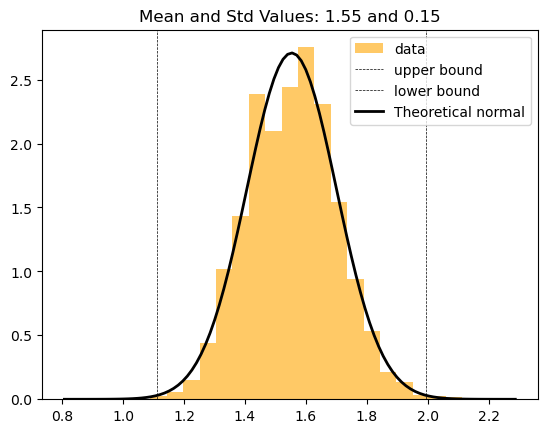

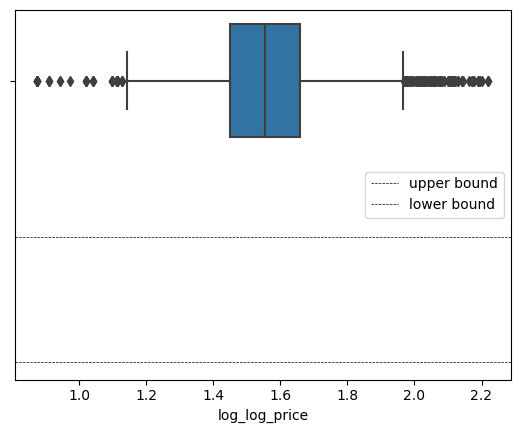

<Figure size 640x480 with 0 Axes>

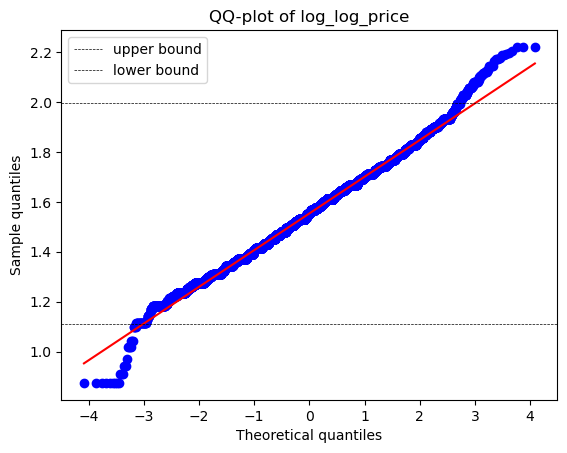

In [4]:
df = data.copy()

# Remove entries with no price
df = df[df['price']!=0]
df = df[df['availability_365']!=0]

# Replace NaN values by 0
df['number_of_reviews'].fillna(0, inplace=True)
df['reviews_per_month'].fillna(0, inplace=True)
df['name'].fillna('Unnamed', inplace=True)
df['last_review'].fillna('2099-01-01',inplace=True)

#log price

# We will trim out the outliers using the log log price distribution
df['log_log_price'] = np.log(np.log(1+df['price']))

# We compute the upper and lower thresholds
u,l = compare_norm_dist(df['log_log_price'], True)

# We keep only the datapoints within the thresholds
df = df[(df['log_log_price']>l)&(df['log_log_price']<u)]

df.shape

# Preprocessing

In [5]:
X_train, X_test, y_train, y_test = preprocess(file_path)

# Feature Selection

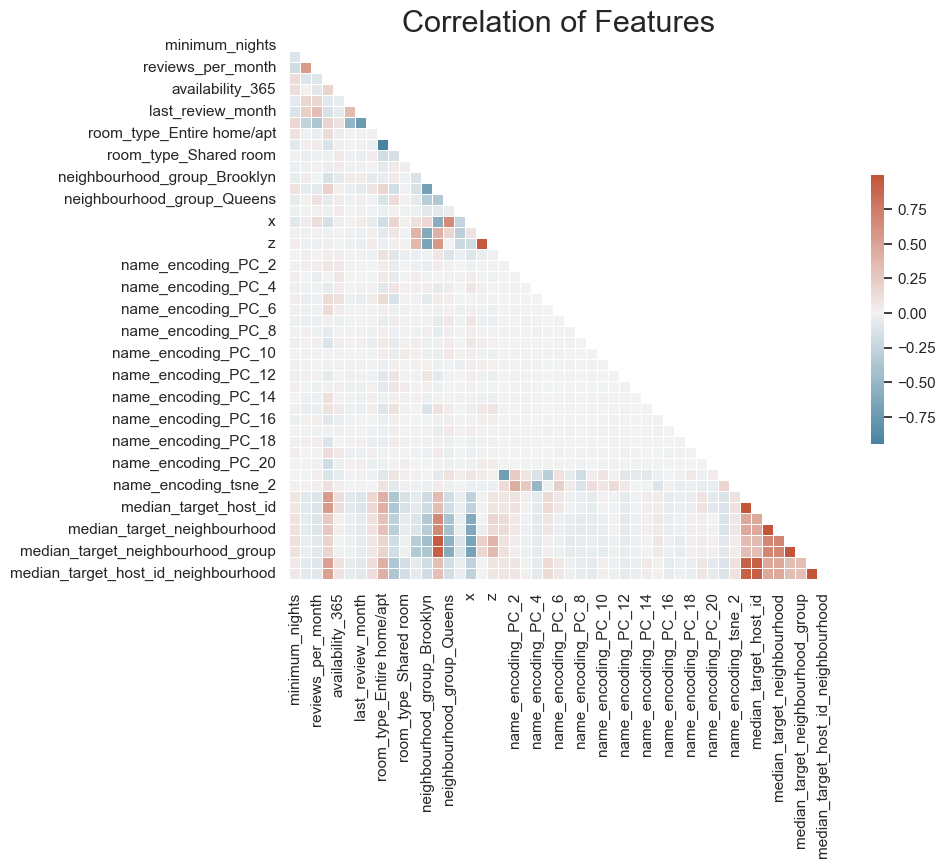

In [6]:
### What about correlations?

# Change the style theme
sns.set(style = "white")

# Compute the correlation matrix
#corr = df.drop(list_log_num_features, axis = 1).corr()
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

# Set up the matplotlib figure
fig, axes = plt.subplots(figsize = (11, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

plt.title("Correlation of Features", fontsize = 22)
plt.show()

In [216]:
print(list(X_train.columns))

['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'last_review_day', 'last_review_month', 'last_review_year', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'x', 'y', 'z', 'name_encoding_PC_1', 'name_encoding_PC_2', 'name_encoding_PC_3', 'name_encoding_PC_4', 'name_encoding_PC_5', 'name_encoding_PC_6', 'name_encoding_PC_7', 'name_encoding_PC_8', 'name_encoding_PC_9', 'name_encoding_PC_10', 'name_encoding_PC_11', 'name_encoding_PC_12', 'name_encoding_PC_13', 'name_encoding_PC_14', 'name_encoding_PC_15', 'name_encoding_PC_16', 'name_encoding_PC_17', 'name_encoding_PC_18', 'name_encoding_PC_19', 'name_encoding_PC_20', 'name_encoding_tsne_1', 'name_encoding_tsne_2', 'mean_target_host_id', 'median_target_host_id', 'mean_target_neighbour

In [1]:
# Only keep columns of interest
selected_features = list(X_train.columns)
# selected_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'last_review_day', 'last_review_month', 'last_review_year', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'mean_target_host_id','mean_target_neighbourhood','mean_target_host_id_neighbourhood','neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'x', 'y', 'z','name_encoding_tsne_1', 'name_encoding_tsne_2']

# Prepare feature matrices
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()

scaler = MinMaxScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

y_train_np = y_train.to_numpy().flatten()
y_test_np = y_test.to_numpy().flatten()

X_test_selected

NameError: name 'X_train' is not defined

# Decision Trees

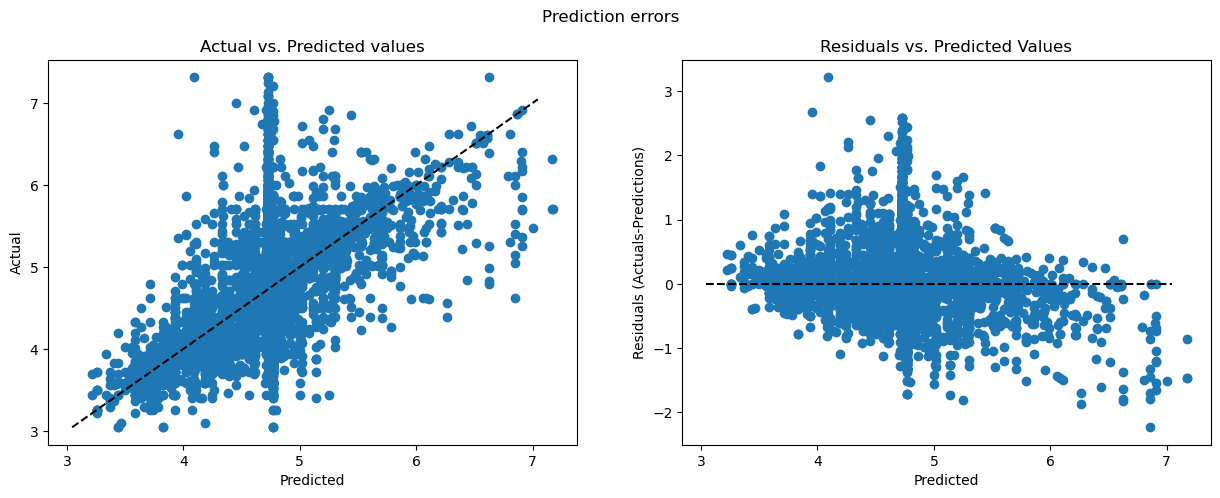

R²: 0.24242076822100822
MAE: 0.45321958733610673
MSE: 0.3670644471195244
RMSE: 0.6058584381846344
MAPE: 0.09355225141100897
error_ratio_rmse: 0.12666976247105285
error_ratio_mae: 0.0947568175283842


In [286]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train_np, y_train_np)
y_pred_dt_reg = dt_reg.predict(X_test_np)
dt_reg_scores = scores(y_test_np,y_pred_dt_reg,plot=True)

# Bagging

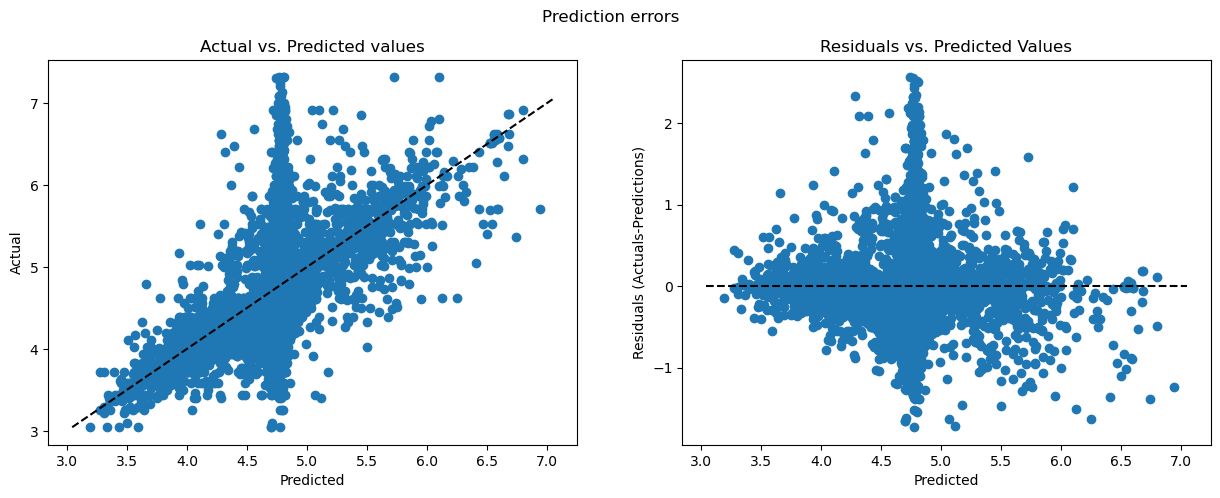

R²: 0.35010142944892086
MAE: 0.41062058770785065
MSE: 0.31489070644520323
RMSE: 0.5611512331316784
MAPE: 0.08471528698109518
error_ratio_rmse: 0.1173226102521763
error_ratio_mae: 0.0858504380437904


In [267]:
bag = BaggingRegressor().fit(X_train_np, y_train_np)
y_pred_bag = bag.predict(X_test_np)
bag_scores=scores(y_test_np,y_pred_bag,plot=True)

# Random Forest

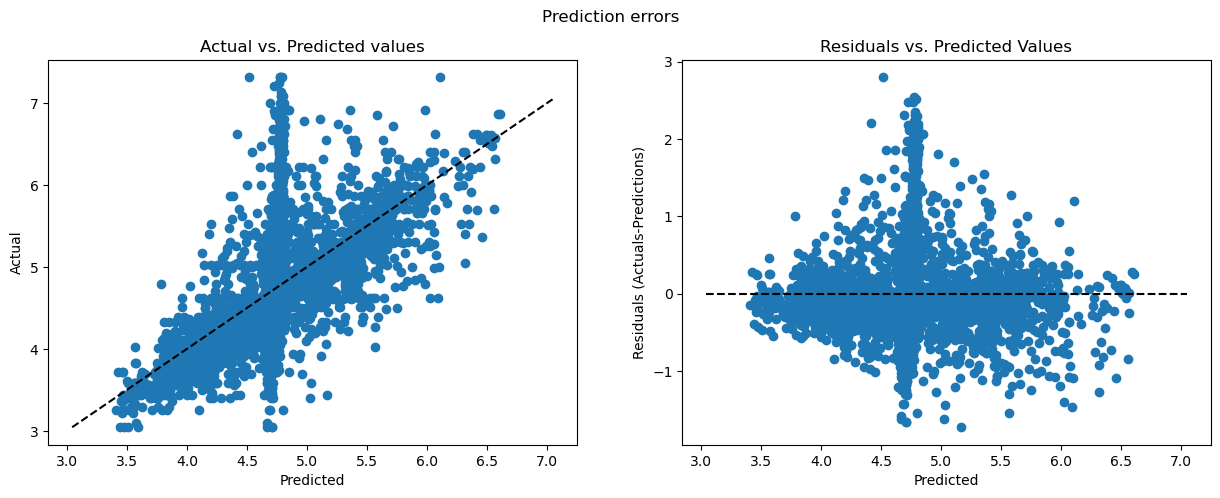

R²: 0.3479369055686987
MAE: 0.41972020067676513
MSE: 0.3159394677206477
RMSE: 0.5620849292772825
MAPE: 0.08684071316039949
error_ratio_rmse: 0.1175178226343595
error_ratio_mae: 0.08775293826612723


In [287]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 12, random_state = 18).fit(X_train_np, y_train_np)
y_pred_random_forest = rf.predict(X_test_np)
random_forest_scores=scores(y_test_np,y_pred_random_forest,plot=True)

# ADABOOST

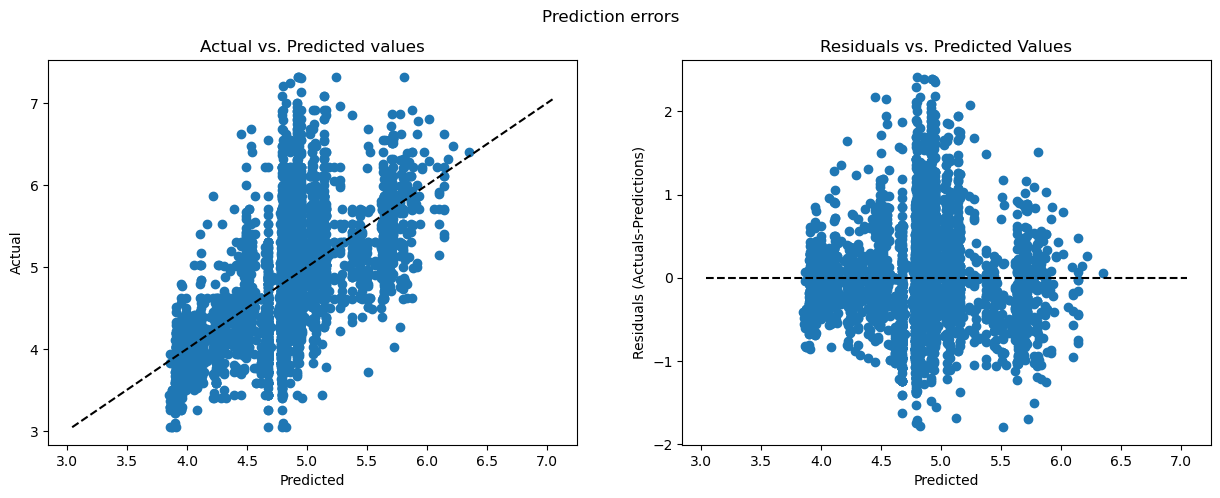

R²: 0.3817666800651701
MAE: 0.4204401896599775
MSE: 0.29954816902761794
RMSE: 0.5473099387254153
MAPE: 0.08842977778693466
error_ratio_rmse: 0.1144287436915542
error_ratio_mae: 0.08790346985525316


In [269]:
ada = AdaBoostRegressor().fit(X_train_np, y_train_np)
y_pred_ada = ada.predict(X_test_np)
ada_scores=scores(y_test_np,y_pred_ada,plot= True)

# Gradient Boosting

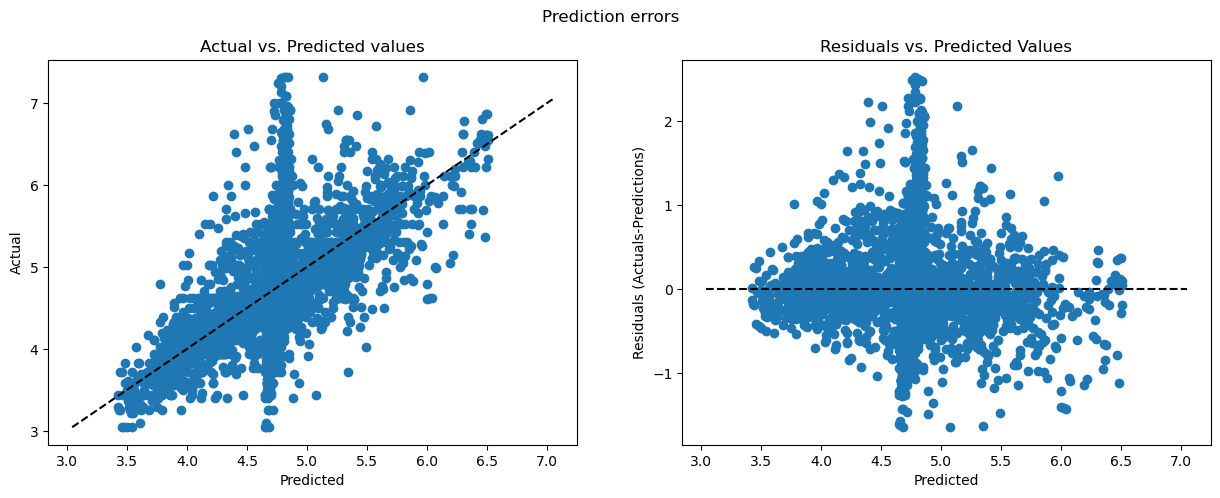

R²: 0.37904141754439225
MAE: 0.40450344286567086
MSE: 0.3008686209862808
RMSE: 0.5485149232120132
MAPE: 0.08334343856239138
error_ratio_rmse: 0.11468067564311042
error_ratio_mae: 0.08457149689958239


In [270]:
gbr = GradientBoostingRegressor().fit(X_train_np, y_train_np)
y_pred_gbr = gbr.predict(X_test_np)
gbr_scores=scores(y_test_np,y_pred_gbr,plot= True)

# Hist Gradient Boosting

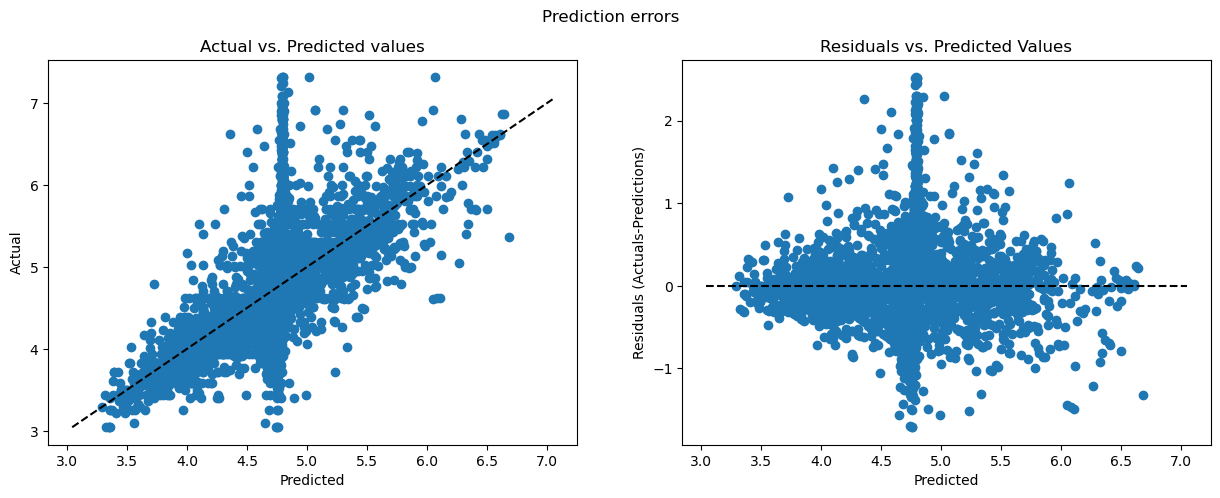

R²: 0.36753375832856927
MAE: 0.4067551135032561
MSE: 0.30644434480565846
RMSE: 0.5535741547486285
MAPE: 0.08408308640618149
error_ratio_rmse: 0.11573843372096988
error_ratio_mae: 0.08504226460182085


In [271]:
hgbr = HistGradientBoostingRegressor().fit(X_train_np, y_train_np)
y_pred_hgbr = hgbr.predict(X_test_np)
hgbr_scores=scores(y_test_np,y_pred_hgbr,plot= True)

# Light GBM

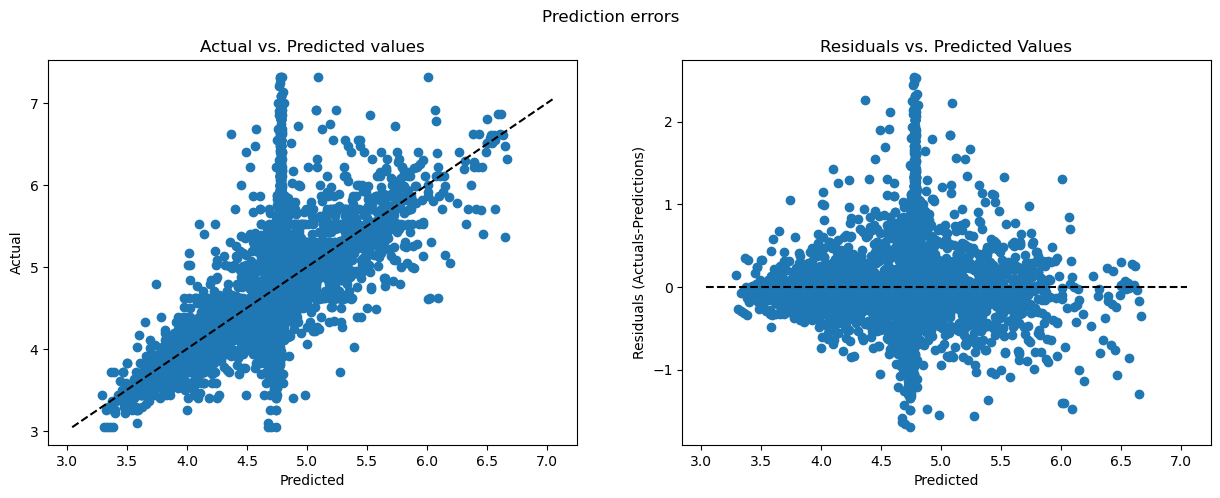

R²: 0.365701991241556
MAE: 0.40731388312380834
MSE: 0.30733187781189913
RMSE: 0.5543752139227539
MAPE: 0.08403121548912725
error_ratio_rmse: 0.11590591504815212
error_ratio_mae: 0.0851590892767787


In [272]:
lgbm = LGBMRegressor().fit(X_train_np, y_train_np)
y_pred_lgbm = lgbm.predict(X_test_np)
lgbm_scores=scores(y_test_np,y_pred_lgbm,plot= True)

# XGBOOST

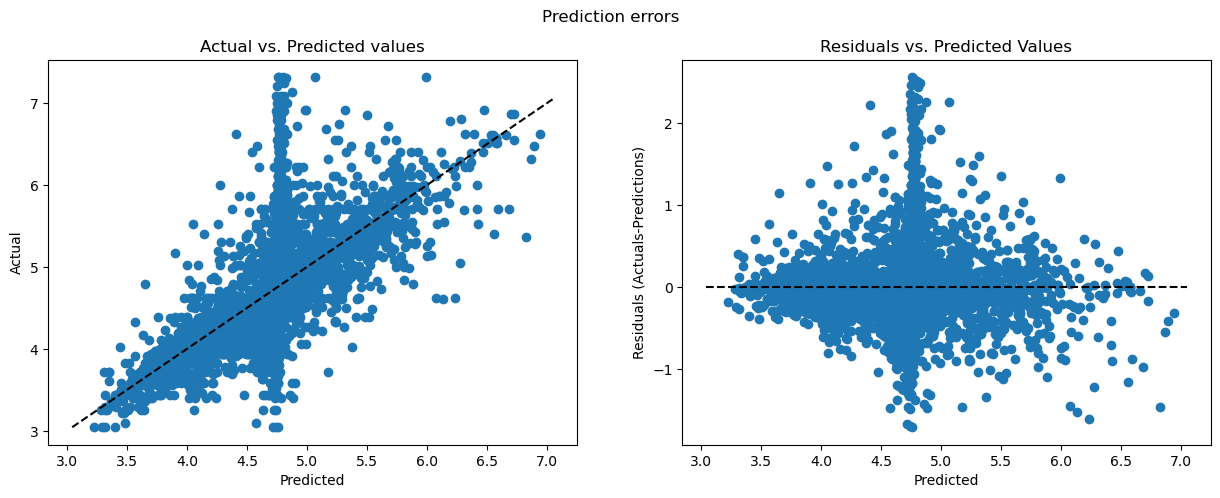

R²: 0.3654795677509076
MAE: 0.40597993823571155
MSE: 0.30743964707509486
RMSE: 0.5544724042502881
MAPE: 0.0836309946878934
error_ratio_rmse: 0.11592623510136477
error_ratio_mae: 0.08488019494854092


In [273]:
xgb = xg.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse').fit(X_train_np, y_train_np)
y_pred_xgb = xgb.predict(X_test_np)
xgb_scores=scores(y_test_np,y_pred_xgb,plot= True)

In [257]:
space={'max_depth': hp.quniform("max_depth", 3, 40, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,280,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,150),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 400, 1),
        'seed': hp.quniform('seed', 0, 400, 1)
    }

In [258]:
def objective(space):
    mod=xg.XGBRegressor(
                          n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=space['colsample_bytree'],
                          seed = int(space['seed']),
                          objective = 'reg:squarederror', 
                          eval_metric = 'rmse'
                       )
    
    evaluation = [( X_train_np, y_train_np), ( X_test_np, y_test_np)]
    
    mod.set_params(eval_metric="rmse",early_stopping_rounds=10,)
    mod.fit(X_train_np, y_train_np,eval_set=evaluation,verbose=False)

    y_pred = mod.predict(X_test_np)
    score = scores(y_test_np,y_pred)['RMSE']
    print ("SCORE:", score)
    return {'loss': score, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

R²: 0.4582134328736599                                                                                                 
MAE: 0.3848714465097877                                                                                                
MSE: 0.26250797062112646                                                                                               
RMSE: 0.5123553167686722                                                                                               
MAPE: 0.08001903461545518                                                                                              
error_ratio_rmse: 0.10712061132685026                                                                                  
error_ratio_mae: 0.08046694019375591                                                                                   
SCORE:                                                                                                                 
0.5123553167686722                      

MAE: 0.3767233441207594                                                                                                
MSE: 0.2538515708992979                                                                                                
RMSE: 0.5038368494853248                                                                                               
MAPE: 0.07822262825799947                                                                                              
error_ratio_rmse: 0.10533961405192213                                                                                  
error_ratio_mae: 0.078763376903789                                                                                     
SCORE:                                                                                                                 
0.5038368494853248                                                                                                     
R²: 0.3955202585727865                  

MSE: 0.23817406487997933                                                                                               
RMSE: 0.48803080320813697                                                                                              
MAPE: 0.0767639118963416                                                                                               
error_ratio_rmse: 0.10203496728734625                                                                                  
error_ratio_mae: 0.07679595996924919                                                                                   
SCORE:                                                                                                                 
0.48803080320813697                                                                                                    
R²: 0.545474926629465                                                                                                  
MAE: 0.3419737468729605                 

RMSE: 0.5360321959432921                                                                                               
MAPE: 0.08365791913224511                                                                                              
error_ratio_rmse: 0.1120708513038512                                                                                   
error_ratio_mae: 0.08415343438416366                                                                                   
SCORE:                                                                                                                 
0.5360321959432921                                                                                                     
R²: 0.4051340502400542                                                                                                 
MAE: 0.40443288786723747                                                                                               
MSE: 0.28822614427551474                

MAPE: 0.08988508545628943                                                                                              
error_ratio_rmse: 0.11865281485080367                                                                                  
error_ratio_mae: 0.08984715001954277                                                                                   
SCORE:                                                                                                                 
0.5675135698477874                                                                                                     
R²: 0.5101276075208373                                                                                                 
MAE: 0.3619952421324925                                                                                                
MSE: 0.23735436685906905                                                                                               
RMSE: 0.48719027787823216               

error_ratio_rmse: 0.10770961916986432                                                                                  
error_ratio_mae: 0.08077127434327054                                                                                   
SCORE:                                                                                                                 
0.5151725271658935                                                                                                     
R²: 0.4368378179865805                                                                                                 
MAE: 0.3918462556120309                                                                                                
MSE: 0.27286494442826303                                                                                               
RMSE: 0.5223647618554137                                                                                               
MAPE: 0.08128946222440052               

error_ratio_mae: 0.08264699648675157                                                                                   
SCORE:                                                                                                                 
0.5185989568603967                                                                                                     
R²: 0.43102934926085223                                                                                                
MAE: 0.384982429297419                                                                                                 
MSE: 0.2756792802389397                                                                                                
RMSE: 0.5250516929207444                                                                                               
MAPE: 0.07820999439978472                                                                                              
error_ratio_rmse: 0.10977510427448503   

In [259]:
best_hyperparams

{'colsample_bytree': 0.5492781194912929,
 'gamma': 5.631949367643904,
 'max_depth': 25.0,
 'min_child_weight': 1.0,
 'n_estimators': 102.0,
 'reg_alpha': 280.0,
 'reg_lambda': 143.96997232898997,
 'seed': 52.0}

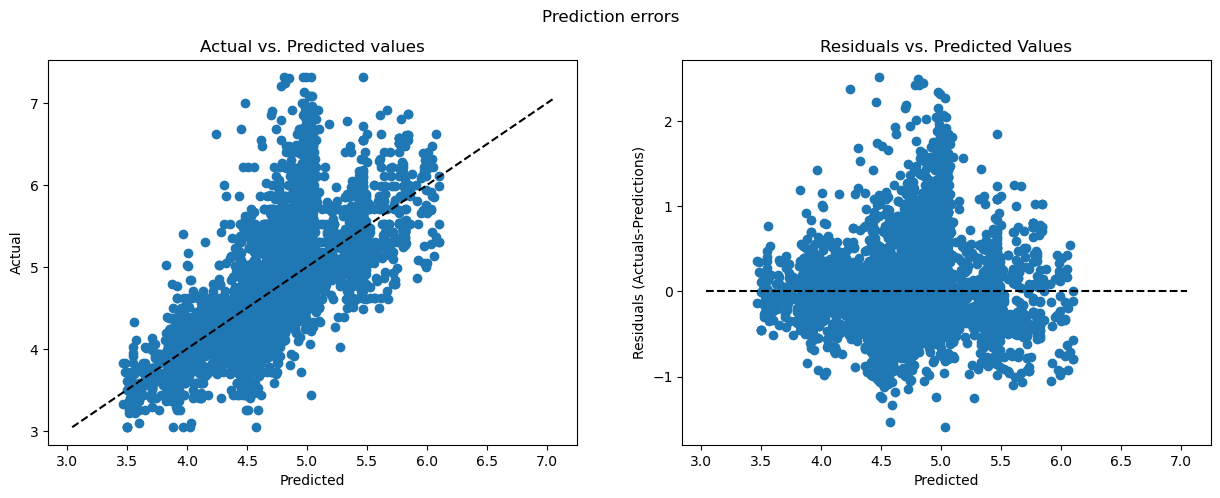

R²: 0.49879294691054366
MAE: 0.3650922224176712
MSE: 0.24284626890136082
RMSE: 0.49279434747302125
MAPE: 0.07477965309707407
error_ratio_rmse: 0.10303090459303307
error_ratio_mae: 0.07633160187096673


In [260]:
xgb_tuned = xg.XGBRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          gamma = best_hyperparams['gamma'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          seed = int(best_hyperparams['seed']),
                          objective = 'reg:squarederror',
                          eval_metric = 'rmse'
                       )

xgb_tuned.fit(X_train_np, y_train_np)#,eval_set=evaluation, eval_metric="rmse",early_stopping_rounds=10,verbose=False)

y_pred = xgb_tuned.predict(X_test_np)
score = scores(y_test_np,y_pred,plot=True)